In [1]:
import os
import re
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import ViTModel, ViTConfig
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Configuration
data_dir = r"F:/Education/NSU/CSE/CSE499/Implementation/Image Data"
gray_image_dir = os.path.join(data_dir, "gray_image")
even_dir = os.path.join(gray_image_dir, "even_images")
odd_dir = os.path.join(gray_image_dir, "odd_images")
matrix_dir = os.path.join(data_dir, "matrix")
image_size = (50, 50)
batch_size = 8
num_epochs = 10
learning_rate = 2e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Custom Dataset
class ImagePairDataset(Dataset):
    def __init__(self, even_dir, odd_dir, matrix_dir, transform=None):
        self.even_dir = even_dir
        self.odd_dir = odd_dir
        self.matrix_dir = matrix_dir
        self.transform = transform
        
        # Get list of image IDs from even_images (assuming same IDs in odd_images)
        even_files = [f for f in os.listdir(even_dir) if f.endswith("_even.png")]
        self.ids = []
        for f in even_files:
            match = re.match(r"(\d+)_even\.png", f)
            if match:
                id_str = match.group(1)
                odd_file = f"{id_str}_odd.png"
                matrix_file = f"{id_str}.png"
                if (os.path.exists(os.path.join(odd_dir, odd_file)) and 
                    os.path.exists(os.path.join(matrix_dir, matrix_file))):
                    self.ids.append(id_str)
        
        print(f"Found {len(self.ids)} matching image pairs")
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        id_str = self.ids[idx]
        
        # Load even and odd images
        even_img = Image.open(os.path.join(self.even_dir, f"{id_str}_even.png")).convert("L")
        odd_img = Image.open(os.path.join(self.odd_dir, f"{id_str}_odd.png")).convert("L")
        matrix_img = Image.open(os.path.join(self.matrix_dir, f"{id_str}.png")).convert("L")
        
        # Convert to numpy and normalize
        even_img = np.array(even_img, dtype=np.float32) / 255.0
        odd_img = np.array(odd_img, dtype=np.float32) / 255.0
        matrix_img = np.array(matrix_img, dtype=np.float32) / 255.0
        
        # Combine even and odd into 2-channel input
        input_img = np.stack([even_img, odd_img], axis=2)  # Shape: (50, 50, 2)
        
        # Convert to torch tensors
        input_img = torch.tensor(input_img).permute(2, 0, 1)  # Shape: (2, 50, 50)
        matrix_img = torch.tensor(matrix_img).flatten()  # Shape: (2500,)
        
        return input_img, matrix_img


In [4]:
# Custom ViT Model for Regression
class ViTForImageRegression(nn.Module):
    def __init__(self, model_name="google/vit-base-patch16-224"):
        super(ViTForImageRegression, self).__init__()
        self.vit = ViTModel.from_pretrained(model_name)
        self.vit.config.patch_size = 10  # Adjust for 50x50 input
        self.regressor = nn.Linear(self.vit.config.hidden_size, 50 * 50)  # Output 50x50 pixels
    
    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output  # [CLS] token
        return self.regressor(pooled_output)

In [5]:
# Compute SSIM for a batch
def compute_batch_ssim(preds, targets, size=(50, 50)):
    ssim_scores = []
    preds = preds.cpu().numpy().reshape(-1, *size)
    targets = targets.cpu().numpy().reshape(-1, *size)
    for i in range(len(preds)):
        score = ssim(preds[i], targets[i], data_range=1.0)
        ssim_scores.append(score)
    return np.mean(ssim_scores)



In [6]:
# Training and Evaluation
def train_model():
    # Initialize dataset and dataloader
    dataset = ImagePairDataset(even_dir, odd_dir, matrix_dir)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model
    model = ViTForImageRegression().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_mse = 0.0
        train_mae = 0.0
        train_ssim = 0.0
        num_batches = 0
        
        for inputs, targets in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Compute metrics
            train_loss += loss.item()
            preds = outputs.detach()
            train_mse += mean_squared_error(targets.cpu().numpy(), preds.cpu().numpy())
            train_mae += mean_absolute_error(targets.cpu().numpy(), preds.cpu().numpy())
            train_ssim += compute_batch_ssim(preds, targets)
            num_batches += 1
        
        # Average metrics
        train_loss /= num_batches
        train_mse /= num_batches
        train_mae /= num_batches
        train_ssim /= num_batches
        
        print(f"Epoch {epoch + 1}:")
        print(f"  Train Loss: {train_loss:.6f}")
        print(f"  Train MSE: {train_mse:.6f}")
        print(f"  Train MAE: {train_mae:.6f}")
        print(f"  Train SSIM: {train_ssim:.4f}")
        
        # Visualize a sample prediction
        if epoch == num_epochs - 1:
            model.eval()
            with torch.no_grad():
                sample_inputs, sample_targets = next(iter(dataloader))
                sample_inputs = sample_inputs[:2].to(device)
                sample_preds = model(sample_inputs)
                
                fig, axes = plt.subplots(2, 2, figsize=(10, 10))
                for i in range(2):
                    pred_img = sample_preds[i].cpu().numpy().reshape(image_size)
                    target_img = sample_targets[i].cpu().numpy().reshape(image_size)
                    
                    axes[i, 0].imshow(pred_img, cmap='gray')
                    axes[i, 0].set_title(f"Predicted Image {i + 1}")
                    axes[i, 0].axis('off')
                    
                    axes[i, 1].imshow(target_img, cmap='gray')
                    axes[i, 1].set_title(f"Target Image {i + 1}")
                    axes[i, 1].axis('off')
                
                plt.show()



In [7]:
if __name__ == "__main__":
    train_model()

Found 1161 matching image pairs


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

C:\Users\User\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--google--vit-base-patch16-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download

(…)dda6f3b8b58e7256e8f44b4ea6aa9696162ccb5d:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10:   0%|                                                                              | 0/146 [00:00<?, ?it/s]


ValueError: Make sure that the channel dimension of the pixel values match with the one set in the configuration. Expected 3 but got 2.

In [8]:
pip install torch transformers pillow numpy scikit-image scikit-learn tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install hf_xet

   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.7 MB ? eta -:--:--
   -------------------------- ------------- 1.8/2.7 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 7.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import re
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import ViTModel, ViTConfig
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configuration
data_dir = r"F:/Education/NSU/CSE/CSE499/Implementation/Image Data"
gray_image_dir = os.path.join(data_dir, "gray_image")
even_dir = os.path.join(gray_image_dir, "even_images")
odd_dir = os.path.join(gray_image_dir, "odd_images")
matrix_dir = os.path.join(data_dir, "matrix")
image_size = (50, 50)
batch_size = 8
num_epochs = 10
learning_rate = 2e-5
train_split = 0.8  # 80% train, 20% test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class ImagePairDataset(Dataset):
    def __init__(self, even_dir, odd_dir, matrix_dir):
        self.even_dir = even_dir
        self.odd_dir = odd_dir
        self.matrix_dir = matrix_dir
        
        # Get list of image IDs
        even_files = [f for f in os.listdir(even_dir) if f.endswith("_even.png")]
        self.ids = []
        for f in even_files:
            match = re.match(r"(\d+)_even\.png", f)
            if match:
                id_str = match.group(1)
                odd_file = f"{id_str}_odd.png"
                matrix_file = f"{id_str}.png"
                if (os.path.exists(os.path.join(odd_dir, odd_file)) and 
                    os.path.exists(os.path.join(matrix_dir, matrix_file))):
                    self.ids.append(id_str)
        
        print(f"Found {len(self.ids)} matching image pairs")
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        id_str = self.ids[idx]
        
        # Load images
        even_img = Image.open(os.path.join(self.even_dir, f"{id_str}_even.png")).convert("L")
        odd_img = Image.open(os.path.join(self.odd_dir, f"{id_str}_odd.png")).convert("L")
        matrix_img = Image.open(os.path.join(self.matrix_dir, f"{id_str}.png")).convert("L")
        
        # Convert to numpy and normalize
        even_img = np.array(even_img, dtype=np.float32) / 255.0
        odd_img = np.array(odd_img, dtype=np.float32) / 255.0
        matrix_img = np.array(matrix_img, dtype=np.float32) / 255.0
        
        # Combine into 2-channel input
        input_img = np.stack([even_img, odd_img], axis=2)  # Shape: (50, 50, 2)
        
        # Convert to torch tensors
        input_img = torch.tensor(input_img).permute(2, 0, 1)  # Shape: (2, 50, 50)
        matrix_img = torch.tensor(matrix_img).flatten()  # Shape: (2500,)
        
        return input_img, matrix_img

# Custom ViT Model for Regression
class ViTForImageRegression(nn.Module):
    def __init__(self):
        super(ViTForImageRegression, self).__init__()
        # Custom ViT configuration for 2-channel 50x50 images
        config = ViTConfig(
            image_size=50,
            patch_size=10,  # 50x50 divides evenly into 5x5 patches
            num_channels=2,  # 2-channel input
            hidden_size=768,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072
        )
        self.vit = ViTModel(config)
        self.regressor = nn.Linear(config.hidden_size, 50 * 50)  # Output 50x50 pixels
    
    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output
        return self.regressor(pooled_output)

# Compute SSIM for a batch
def compute_batch_ssim(preds, targets, size=(50, 50)):
    ssim_scores = []
    preds = preds.cpu().numpy().reshape(-1, *size)
    targets = targets.cpu().numpy().reshape(-1, *size)
    for i in range(len(preds)):
        score = ssim(preds[i], targets[i], data_range=1.0)
        ssim_scores.append(score)
    return np.mean(ssim_scores)

# Training and Evaluation
def train_model():
    # Initialize dataset and split
    dataset = ImagePairDataset(even_dir, odd_dir, matrix_dir)
    train_size = int(train_split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = ViTForImageRegression().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_mse = 0.0
        train_mae = 0.0
        train_ssim = 0.0
        num_batches = 0
        
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Compute metrics
            train_loss += loss.item()
            preds = outputs.detach()
            train_mse += mean_squared_error(targets.cpu().numpy(), preds.cpu().numpy())
            train_mae += mean_absolute_error(targets.cpu().numpy(), preds.cpu().numpy())
            train_ssim += compute_batch_ssim(preds, targets)
            num_batches += 1
        
        # Average metrics
        train_loss /= num_batches
        train_mse /= num_batches
        train_mae /= num_batches
        train_ssim /= num_batches
        
        # Evaluate on test set
        model.eval()
        test_loss = 0.0
        test_mse = 0.0
        test_mae = 0.0
        test_ssim = 0.0
        num_test_batches = 0
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item()
                test_mse += mean_squared_error(targets.cpu().numpy(), outputs.cpu().numpy())
                test_mae += mean_absolute_error(targets.cpu().numpy(), outputs.cpu().numpy())
                test_ssim += compute_batch_ssim(outputs, targets)
                num_test_batches += 1
        
        test_loss /= num_test_batches
        test_mse /= num_test_batches
        test_mae /= num_test_batches
        test_ssim /= num_test_batches
        
        print(f"Epoch {epoch + 1}:")
        print(f"  Train Loss: {train_loss:.6f}, MSE: {train_mse:.6f}, MAE: {train_mae:.6f}, SSIM: {train_ssim:.4f}")
        print(f"  Test Loss: {test_loss:.6f}, MSE: {test_mse:.6f}, MAE: {test_mae:.6f}, SSIM: {test_ssim:.4f}")
        
        # Visualize sample predictions
        if epoch == num_epochs - 1:
            with torch.no_grad():
                sample_inputs, sample_targets = next(iter(test_loader))
                sample_inputs = sample_inputs[:2].to(device)
                sample_preds = model(sample_inputs)
                
                fig, axes = plt.subplots(2, 2, figsize=(10, 10))
                for i in range(2):
                    pred_img = sample_preds[i].cpu().numpy().reshape(image_size)
                    target_img = sample_targets[i].cpu().numpy().reshape(image_size)
                    
                    axes[i, 0].imshow(pred_img, cmap='gray')
                    axes[i, 0].set_title(f"Predicted Image {i + 1}")
                    axes[i, 0].axis('off')
                    
                    axes[i, 1].imshow(target_img, cmap='gray')
                    axes[i, 1].set_title(f"Target Image {i + 1}")
                    axes[i, 1].axis('off')
                
                plt.show()

if __name__ == "__main__":
    train_model()

Found 1161 matching image pairs


Epoch 1/10:   0%|                                                                              | 0/116 [00:00<?, ?it/s]


ValueError: Input image size (32*32) doesn't match model (50*50).

Found 1161 matching image pairs


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████| 116/116 [00:54<00:00,  2.13it/s]


Epoch 1:
  Train Loss: 0.312746, MSE: 0.312746, MAE: 0.508686, SSIM: 0.0189
  Test Loss: 0.252115, MSE: 0.252115, MAE: 0.499534, SSIM: 0.0711


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████| 116/116 [00:47<00:00,  2.43it/s]


Epoch 2:
  Train Loss: 0.250286, MSE: 0.250286, MAE: 0.497794, SSIM: 0.0835
  Test Loss: 0.249805, MSE: 0.249805, MAE: 0.496010, SSIM: 0.0748


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████| 116/116 [00:47<00:00,  2.46it/s]


Epoch 3:
  Train Loss: 0.248170, MSE: 0.248170, MAE: 0.493898, SSIM: 0.0861
  Test Loss: 0.248273, MSE: 0.248273, MAE: 0.493984, SSIM: 0.0933


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████| 116/116 [00:46<00:00,  2.47it/s]


Epoch 4:
  Train Loss: 0.247287, MSE: 0.247287, MAE: 0.492253, SSIM: 0.0951
  Test Loss: 0.248706, MSE: 0.248706, MAE: 0.493606, SSIM: 0.0895


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████| 116/116 [00:46<00:00,  2.47it/s]


Epoch 5:
  Train Loss: 0.247486, MSE: 0.247486, MAE: 0.492066, SSIM: 0.0964
  Test Loss: 0.247491, MSE: 0.247491, MAE: 0.493641, SSIM: 0.1028


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████| 116/116 [00:47<00:00,  2.46it/s]


Epoch 6:
  Train Loss: 0.246874, MSE: 0.246874, MAE: 0.491326, SSIM: 0.1019
  Test Loss: 0.247176, MSE: 0.247176, MAE: 0.491491, SSIM: 0.1067


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████| 116/116 [00:46<00:00,  2.48it/s]


Epoch 7:
  Train Loss: 0.246818, MSE: 0.246818, MAE: 0.491049, SSIM: 0.1055
  Test Loss: 0.247679, MSE: 0.247679, MAE: 0.491856, SSIM: 0.1177


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████| 116/116 [00:46<00:00,  2.50it/s]


Epoch 8:
  Train Loss: 0.246391, MSE: 0.246391, MAE: 0.490368, SSIM: 0.1072
  Test Loss: 0.248773, MSE: 0.248773, MAE: 0.492344, SSIM: 0.0918


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████| 116/116 [00:46<00:00,  2.49it/s]


Epoch 9:
  Train Loss: 0.246246, MSE: 0.246246, MAE: 0.490015, SSIM: 0.1094
  Test Loss: 0.247747, MSE: 0.247747, MAE: 0.492391, SSIM: 0.1201


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████| 116/116 [00:46<00:00,  2.49it/s]


Epoch 10:
  Train Loss: 0.245807, MSE: 0.245807, MAE: 0.489832, SSIM: 0.1140
  Test Loss: 0.246949, MSE: 0.246949, MAE: 0.492189, SSIM: 0.1146


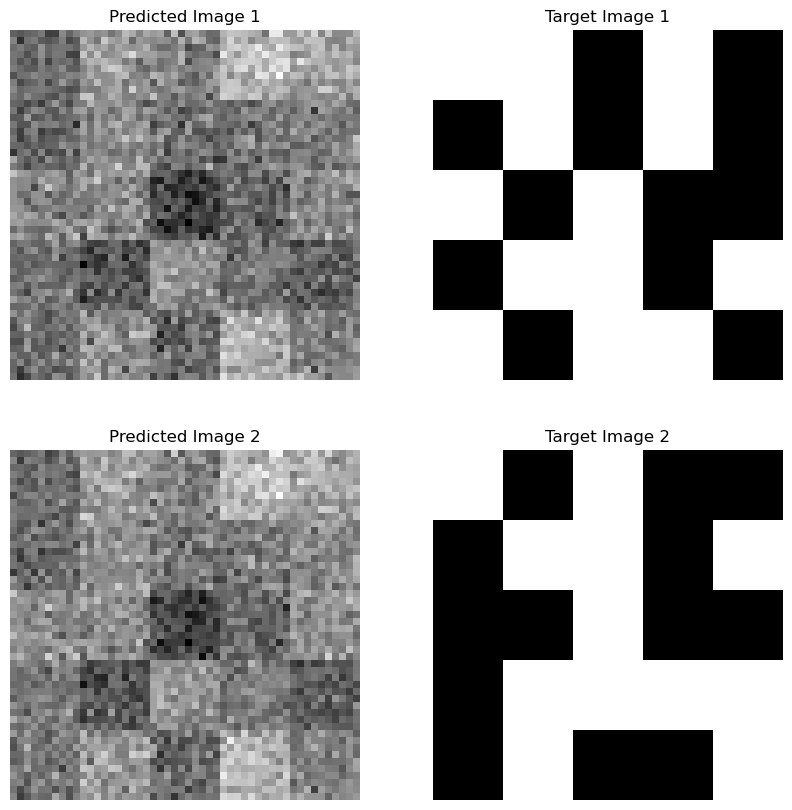

In [1]:
import os
import re
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import ViTModel, ViTConfig
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configuration
data_dir = r"F:/Education/NSU/CSE/CSE499/Implementation/Image Data"
gray_image_dir = os.path.join(data_dir, "gray_image")
even_dir = os.path.join(gray_image_dir, "even_images")
odd_dir = os.path.join(gray_image_dir, "odd_images")
matrix_dir = os.path.join(data_dir, "matrix")
image_size = (50, 50)  # Target size for all images
batch_size = 8
num_epochs = 10
learning_rate = 2e-5
train_split = 0.8  # 80% train, 20% test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class ImagePairDataset(Dataset):
    def __init__(self, even_dir, odd_dir, matrix_dir, target_size=(50, 50)):
        self.even_dir = even_dir
        self.odd_dir = odd_dir
        self.matrix_dir = matrix_dir
        self.target_size = target_size
        
        # Get list of image IDs
        even_files = [f for f in os.listdir(even_dir) if f.endswith("_even.png")]
        self.ids = []
        for f in even_files:
            match = re.match(r"(\d+)_even\.png", f)
            if match:
                id_str = match.group(1)
                odd_file = f"{id_str}_odd.png"
                matrix_file = f"{id_str}.png"
                if (os.path.exists(os.path.join(odd_dir, odd_file)) and 
                    os.path.exists(os.path.join(matrix_dir, matrix_file))):
                    self.ids.append(id_str)
        
        print(f"Found {len(self.ids)} matching image pairs")
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        id_str = self.ids[idx]
        
        # Load images
        even_img = Image.open(os.path.join(self.even_dir, f"{id_str}_even.png")).convert("L")
        odd_img = Image.open(os.path.join(self.odd_dir, f"{id_str}_odd.png")).convert("L")
        matrix_img = Image.open(os.path.join(self.matrix_dir, f"{id_str}.png")).convert("L")
        
        # Resize images to target size
        even_img = even_img.resize(self.target_size, Image.Resampling.LANCZOS)
        odd_img = odd_img.resize(self.target_size, Image.Resampling.LANCZOS)
        matrix_img = matrix_img.resize(self.target_size, Image.Resampling.LANCZOS)
        
        # Convert to numpy and normalize
        even_img = np.array(even_img, dtype=np.float32) / 255.0
        odd_img = np.array(odd_img, dtype=np.float32) / 255.0
        matrix_img = np.array(matrix_img, dtype=np.float32) / 255.0
        
        # Combine into 2-channel input
        input_img = np.stack([even_img, odd_img], axis=2)  # Shape: (50, 50, 2)
        
        # Convert to torch tensors
        input_img = torch.tensor(input_img).permute(2, 0, 1)  # Shape: (2, 50, 50)
        matrix_img = torch.tensor(matrix_img).flatten()  # Shape: (2500,)
        
        return input_img, matrix_img

# Custom ViT Model for Regression
class ViTForImageRegression(nn.Module):
    def __init__(self):
        super(ViTForImageRegression, self).__init__()
        # Custom ViT configuration
        config = ViTConfig(
            image_size=50,
            patch_size=10,  # 50x50 divides into 5x5 patches
            num_channels=2,  # 2-channel input
            hidden_size=768,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072
        )
        self.vit = ViTModel(config)
        self.regressor = nn.Linear(config.hidden_size, 50 * 50)  # Output 50x50 pixels
    
    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output
        return self.regressor(pooled_output)

# Compute SSIM for a batch
def compute_batch_ssim(preds, targets, size=(50, 50)):
    ssim_scores = []
    preds = preds.cpu().numpy().reshape(-1, *size)
    targets = targets.cpu().numpy().reshape(-1, *size)
    for i in range(len(preds)):
        score = ssim(preds[i], targets[i], data_range=1.0)
        ssim_scores.append(score)
    return np.mean(ssim_scores)

# Training and Evaluation
def train_model():
    # Initialize dataset and split
    dataset = ImagePairDataset(even_dir, odd_dir, matrix_dir, target_size=image_size)
    train_size = int(train_split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = ViTForImageRegression().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_mse = 0.0
        train_mae = 0.0
        train_ssim = 0.0
        num_batches = 0
        
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Compute metrics
            train_loss += loss.item()
            preds = outputs.detach()
            train_mse += mean_squared_error(targets.cpu().numpy(), preds.cpu().numpy())
            train_mae += mean_absolute_error(targets.cpu().numpy(), preds.cpu().numpy())
            train_ssim += compute_batch_ssim(preds, targets)
            num_batches += 1
        
        # Average metrics
        train_loss /= num_batches
        train_mse /= num_batches
        train_mae /= num_batches
        train_ssim /= num_batches
        
        # Evaluate on test set
        model.eval()
        test_loss = 0.0
        test_mse = 0.0
        test_mae = 0.0
        test_ssim = 0.0
        num_test_batches = 0
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item()
                test_mse += mean_squared_error(targets.cpu().numpy(), outputs.cpu().numpy())
                test_mae += mean_absolute_error(targets.cpu().numpy(), outputs.cpu().numpy())
                test_ssim += compute_batch_ssim(outputs, targets)
                num_test_batches += 1
        
        test_loss /= num_test_batches
        test_mse /= num_test_batches
        test_mae /= num_test_batches
        test_ssim /= num_test_batches
        
        print(f"Epoch {epoch + 1}:")
        print(f"  Train Loss: {train_loss:.6f}, MSE: {train_mse:.6f}, MAE: {train_mae:.6f}, SSIM: {train_ssim:.4f}")
        print(f"  Test Loss: {test_loss:.6f}, MSE: {test_mse:.6f}, MAE: {test_mae:.6f}, SSIM: {test_ssim:.4f}")
        
        # Visualize sample predictions
        if epoch == num_epochs - 1:
            with torch.no_grad():
                sample_inputs, sample_targets = next(iter(test_loader))
                sample_inputs = sample_inputs[:2].to(device)
                sample_preds = model(sample_inputs)
                
                fig, axes = plt.subplots(2, 2, figsize=(10, 10))
                for i in range(2):
                    pred_img = sample_preds[i].cpu().numpy().reshape(image_size)
                    target_img = sample_targets[i].cpu().numpy().reshape(image_size)
                    
                    axes[i, 0].imshow(pred_img, cmap='gray')
                    axes[i, 0].set_title(f"Predicted Image {i + 1}")
                    axes[i, 0].axis('off')
                    
                    axes[i, 1].imshow(target_img, cmap='gray')
                    axes[i, 1].set_title(f"Target Image {i + 1}")
                    axes[i, 1].axis('off')
                
                plt.show()

if __name__ == "__main__":
    train_model()

Found 1161 matching image pairs


Epoch 1/20: 100%|████████████████████████████████████████████████████████████████████| 116/116 [00:48<00:00,  2.38it/s]


Epoch 1:
  Train Loss: 0.276374, MSE: 0.276374, MAE: 0.496570, SSIM: 0.0417
  Test Loss: 0.247401, MSE: 0.247401, MAE: 0.490353, SSIM: 0.0581
Saved best model at epoch 1 with Test SSIM: 0.0581


Epoch 2/20: 100%|████████████████████████████████████████████████████████████████████| 116/116 [00:48<00:00,  2.37it/s]


Epoch 2:
  Train Loss: 0.246635, MSE: 0.246635, MAE: 0.487813, SSIM: 0.0567
  Test Loss: 0.247000, MSE: 0.247000, MAE: 0.488523, SSIM: 0.0616
Saved best model at epoch 2 with Test SSIM: 0.0616


Epoch 3/20: 100%|████████████████████████████████████████████████████████████████████| 116/116 [00:47<00:00,  2.45it/s]


Epoch 3:
  Train Loss: 0.245547, MSE: 0.245547, MAE: 0.486300, SSIM: 0.0676
  Test Loss: 0.245303, MSE: 0.245303, MAE: 0.486921, SSIM: 0.0676
Saved best model at epoch 3 with Test SSIM: 0.0676


Epoch 4/20: 100%|████████████████████████████████████████████████████████████████████| 116/116 [00:47<00:00,  2.46it/s]


Epoch 4:
  Train Loss: 0.245788, MSE: 0.245788, MAE: 0.486384, SSIM: 0.0672
  Test Loss: 0.245966, MSE: 0.245966, MAE: 0.485915, SSIM: 0.0658


Epoch 5/20: 100%|████████████████████████████████████████████████████████████████████| 116/116 [00:47<00:00,  2.47it/s]


Epoch 5:
  Train Loss: 0.244861, MSE: 0.244861, MAE: 0.485104, SSIM: 0.0727
  Test Loss: 0.245082, MSE: 0.245082, MAE: 0.483192, SSIM: 0.0680
Saved best model at epoch 5 with Test SSIM: 0.0680


Epoch 6/20: 100%|████████████████████████████████████████████████████████████████████| 116/116 [00:46<00:00,  2.48it/s]


Epoch 6:
  Train Loss: 0.245025, MSE: 0.245025, MAE: 0.485262, SSIM: 0.0763
  Test Loss: 0.245446, MSE: 0.245446, MAE: 0.486079, SSIM: 0.0723
Saved best model at epoch 6 with Test SSIM: 0.0723


Epoch 7/20: 100%|████████████████████████████████████████████████████████████████████| 116/116 [00:46<00:00,  2.48it/s]


Epoch 7:
  Train Loss: 0.244898, MSE: 0.244898, MAE: 0.485481, SSIM: 0.0798
  Test Loss: 0.244273, MSE: 0.244273, MAE: 0.485641, SSIM: 0.0824
Saved best model at epoch 7 with Test SSIM: 0.0824


Epoch 8/20: 100%|████████████████████████████████████████████████████████████████████| 116/116 [00:46<00:00,  2.47it/s]


Epoch 8:
  Train Loss: 0.244247, MSE: 0.244247, MAE: 0.484920, SSIM: 0.0826
  Test Loss: 0.243751, MSE: 0.243751, MAE: 0.486308, SSIM: 0.0791


Epoch 9/20: 100%|████████████████████████████████████████████████████████████████████| 116/116 [00:46<00:00,  2.47it/s]


Epoch 9:
  Train Loss: 0.244575, MSE: 0.244575, MAE: 0.484873, SSIM: 0.0811
  Test Loss: 0.244519, MSE: 0.244519, MAE: 0.484764, SSIM: 0.0783


Epoch 10/20: 100%|███████████████████████████████████████████████████████████████████| 116/116 [00:47<00:00,  2.46it/s]


Epoch 10:
  Train Loss: 0.243940, MSE: 0.243940, MAE: 0.484032, SSIM: 0.0847
  Test Loss: 0.244135, MSE: 0.244135, MAE: 0.486347, SSIM: 0.0798


Epoch 11/20: 100%|███████████████████████████████████████████████████████████████████| 116/116 [00:47<00:00,  2.46it/s]


Epoch 11:
  Train Loss: 0.244027, MSE: 0.244027, MAE: 0.484111, SSIM: 0.0844
  Test Loss: 0.242518, MSE: 0.242518, MAE: 0.483718, SSIM: 0.0821


Epoch 12/20: 100%|███████████████████████████████████████████████████████████████████| 116/116 [00:47<00:00,  2.45it/s]


Epoch 12:
  Train Loss: 0.243697, MSE: 0.243697, MAE: 0.484138, SSIM: 0.0865
  Test Loss: 0.242945, MSE: 0.242945, MAE: 0.483558, SSIM: 0.0872
Saved best model at epoch 12 with Test SSIM: 0.0872


Epoch 13/20: 100%|███████████████████████████████████████████████████████████████████| 116/116 [00:47<00:00,  2.45it/s]


Epoch 13:
  Train Loss: 0.243652, MSE: 0.243652, MAE: 0.483541, SSIM: 0.0850
  Test Loss: 0.242194, MSE: 0.242194, MAE: 0.483249, SSIM: 0.0820


Epoch 14/20: 100%|███████████████████████████████████████████████████████████████████| 116/116 [00:47<00:00,  2.46it/s]


Epoch 14:
  Train Loss: 0.242526, MSE: 0.242526, MAE: 0.482070, SSIM: 0.0770
  Test Loss: 0.242068, MSE: 0.242068, MAE: 0.479556, SSIM: 0.0662


Epoch 15/20: 100%|███████████████████████████████████████████████████████████████████| 116/116 [00:46<00:00,  2.48it/s]


Epoch 15:
  Train Loss: 0.241570, MSE: 0.241570, MAE: 0.479549, SSIM: 0.0770
  Test Loss: 0.241369, MSE: 0.241369, MAE: 0.479227, SSIM: 0.0874
Saved best model at epoch 15 with Test SSIM: 0.0874


Epoch 16/20: 100%|███████████████████████████████████████████████████████████████████| 116/116 [00:46<00:00,  2.48it/s]


Epoch 16:
  Train Loss: 0.240691, MSE: 0.240691, MAE: 0.478413, SSIM: 0.0869
  Test Loss: 0.241029, MSE: 0.241030, MAE: 0.479130, SSIM: 0.0843


Epoch 17/20: 100%|███████████████████████████████████████████████████████████████████| 116/116 [00:46<00:00,  2.48it/s]


Epoch 17:
  Train Loss: 0.239836, MSE: 0.239836, MAE: 0.477109, SSIM: 0.0924
  Test Loss: 0.240447, MSE: 0.240447, MAE: 0.478126, SSIM: 0.0953
Saved best model at epoch 17 with Test SSIM: 0.0953


Epoch 18/20: 100%|███████████████████████████████████████████████████████████████████| 116/116 [00:47<00:00,  2.47it/s]


Epoch 18:
  Train Loss: 0.240061, MSE: 0.240061, MAE: 0.477590, SSIM: 0.0952
  Test Loss: 0.240527, MSE: 0.240527, MAE: 0.478856, SSIM: 0.0890


Epoch 19/20: 100%|███████████████████████████████████████████████████████████████████| 116/116 [00:46<00:00,  2.47it/s]


Epoch 19:
  Train Loss: 0.239867, MSE: 0.239867, MAE: 0.477592, SSIM: 0.0989
  Test Loss: 0.239245, MSE: 0.239245, MAE: 0.475519, SSIM: 0.0967
Saved best model at epoch 19 with Test SSIM: 0.0967


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████| 116/116 [00:47<00:00,  2.46it/s]


Epoch 20:
  Train Loss: 0.239396, MSE: 0.239396, MAE: 0.476666, SSIM: 0.1014
  Test Loss: 0.239048, MSE: 0.239048, MAE: 0.476174, SSIM: 0.0980
Saved best model at epoch 20 with Test SSIM: 0.0980


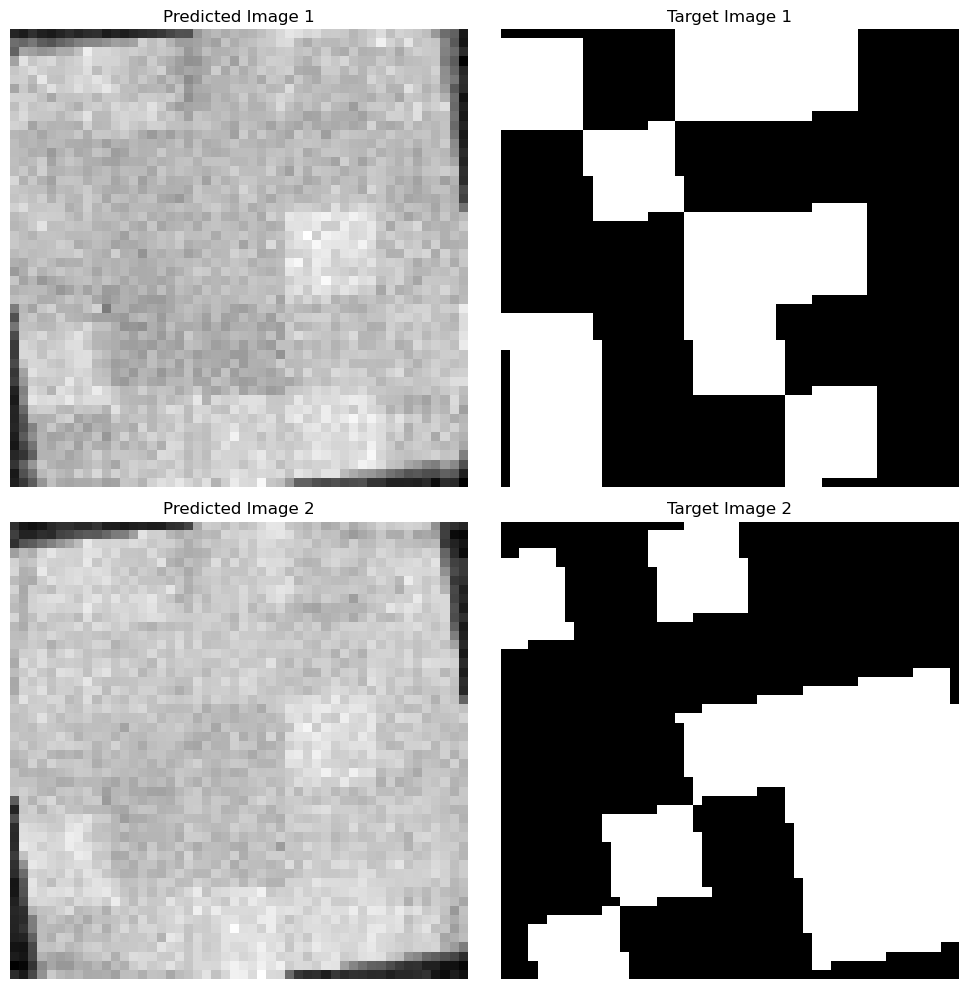

In [4]:
import os
import re
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from transformers import ViTModel, ViTConfig
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Ensure plots display in Jupyter
%matplotlib inline

# Configuration
data_dir = r"F:/Education/NSU/CSE/CSE499/Implementation/Image Data"
gray_image_dir = os.path.join(data_dir, "gray_image")
even_dir = os.path.join(gray_image_dir, "even_images")
odd_dir = os.path.join(gray_image_dir, "odd_images")
matrix_dir = os.path.join(data_dir, "matrix")
image_size = (50, 50)
batch_size = 8
num_epochs = 20  # Increased for better convergence
learning_rate = 5e-5  # Slightly higher for faster learning
train_split = 0.8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_save_path = "best_vit_model.pth"  # Path to save best model

# Data augmentation
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

# Custom Dataset
class ImagePairDataset(Dataset):
    def __init__(self, even_dir, odd_dir, matrix_dir, target_size=(50, 50), transform=None):
        self.even_dir = even_dir
        self.odd_dir = odd_dir
        self.matrix_dir = matrix_dir
        self.target_size = target_size
        self.transform = transform
        
        # Get list of image IDs
        even_files = [f for f in os.listdir(even_dir) if f.endswith("_even.png")]
        self.ids = []
        for f in even_files:
            match = re.match(r"(\d+)_even\.png", f)
            if match:
                id_str = match.group(1)
                odd_file = f"{id_str}_odd.png"
                matrix_file = f"{id_str}.png"
                if (os.path.exists(os.path.join(odd_dir, odd_file)) and 
                    os.path.exists(os.path.join(matrix_dir, matrix_file))):
                    self.ids.append(id_str)
        
        print(f"Found {len(self.ids)} matching image pairs")
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        id_str = self.ids[idx]
        
        # Load images
        even_img = Image.open(os.path.join(self.even_dir, f"{id_str}_even.png")).convert("L")
        odd_img = Image.open(os.path.join(self.odd_dir, f"{id_str}_odd.png")).convert("L")
        matrix_img = Image.open(os.path.join(self.matrix_dir, f"{id_str}.png")).convert("L")
        
        # Resize images
        even_img = even_img.resize(self.target_size, Image.Resampling.LANCZOS)
        odd_img = odd_img.resize(self.target_size, Image.Resampling.LANCZOS)
        matrix_img = matrix_img.resize(self.target_size, Image.Resampling.LANCZOS)
        
        # Verify image sizes
        if even_img.size != self.target_size or odd_img.size != self.target_size or matrix_img.size != self.target_size:
            raise ValueError(f"Image size mismatch for ID {id_str}: expected {self.target_size}")
        
        # Convert to numpy and normalize
        even_img = np.array(even_img, dtype=np.float32) / 255.0
        odd_img = np.array(odd_img, dtype=np.float32) / 255.0
        matrix_img = np.array(matrix_img, dtype=np.float32) / 255.0
        
        # Apply augmentation
        if self.transform:
            # Stack images for consistent augmentation
            stacked_img = np.stack([even_img, odd_img, matrix_img], axis=2)
            stacked_img = Image.fromarray((stacked_img * 255).astype(np.uint8))
            stacked_img = self.transform(stacked_img)
            stacked_img = np.array(stacked_img, dtype=np.float32) / 255.0
            even_img, odd_img, matrix_img = stacked_img[:, :, 0], stacked_img[:, :, 1], stacked_img[:, :, 2]
        
        # Combine into 2-channel input
        input_img = np.stack([even_img, odd_img], axis=2)  # Shape: (50, 50, 2)
        
        # Convert to torch tensors
        input_img = torch.tensor(input_img).permute(2, 0, 1)  # Shape: (2, 50, 50)
        matrix_img = torch.tensor(matrix_img).flatten()  # Shape: (2500,)
        
        return input_img, matrix_img

# Custom ViT Model for Regression
class ViTForImageRegression(nn.Module):
    def __init__(self):
        super(ViTForImageRegression, self).__init__()
        config = ViTConfig(
            image_size=50,
            patch_size=10,
            num_channels=2,
            hidden_size=768,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072
        )
        self.vit = ViTModel(config)
        self.regressor = nn.Linear(config.hidden_size, 50 * 50)
        
        # Optional: Convolutional decoder (uncomment to use)
        # self.decoder = nn.Sequential(
        #     nn.Linear(config.hidden_size, 256 * 5 * 5),
        #     nn.ReLU(),
        #     nn.Unflatten(1, (256, 5, 5)),
        #     nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
        #     nn.Sigmoid()  # Output 50x50x1
        # )
    
    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output
        return self.regressor(pooled_output)
        # For convolutional decoder:
        # return self.decoder(pooled_output).squeeze(1).flatten(1)

# Compute SSIM for a batch
def compute_batch_ssim(preds, targets, size=(50, 50)):
    ssim_scores = []
    preds = preds.cpu().numpy().reshape(-1, *size)
    targets = targets.cpu().numpy().reshape(-1, *size)
    for i in range(len(preds)):
        score = ssim(preds[i], targets[i], data_range=1.0)
        ssim_scores.append(score)
    return np.mean(ssim_scores)

# Training and Evaluation
def train_model():
    # Initialize dataset and split
    dataset = ImagePairDataset(even_dir, odd_dir, matrix_dir, target_size=image_size, transform=transform)
    train_size = int(train_split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = ViTForImageRegression().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    best_test_ssim = 0.0
    best_epoch = 0
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_mse = 0.0
        train_mae = 0.0
        train_ssim = 0.0
        num_batches = 0
        
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Compute metrics
            train_loss += loss.item()
            preds = outputs.detach()
            train_mse += mean_squared_error(targets.cpu().numpy(), preds.cpu().numpy())
            train_mae += mean_absolute_error(targets.cpu().numpy(), preds.cpu().numpy())
            train_ssim += compute_batch_ssim(preds, targets)
            num_batches += 1
        
        # Average train metrics
        train_loss /= num_batches
        train_mse /= num_batches
        train_mae /= num_batches
        train_ssim /= num_batches
        
        # Evaluate on test set
        model.eval()
        test_loss = 0.0
        test_mse = 0.0
        test_mae = 0.0
        test_ssim = 0.0
        num_test_batches = 0
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item()
                test_mse += mean_squared_error(targets.cpu().numpy(), outputs.cpu().numpy())
                test_mae += mean_absolute_error(targets.cpu().numpy(), outputs.cpu().numpy())
                test_ssim += compute_batch_ssim(outputs, targets)
                num_test_batches += 1
        
        test_loss /= num_test_batches
        test_mse /= num_test_batches
        test_mae /= num_test_batches
        test_ssim /= num_test_batches
        
        print(f"Epoch {epoch + 1}:")
        print(f"  Train Loss: {train_loss:.6f}, MSE: {train_mse:.6f}, MAE: {train_mae:.6f}, SSIM: {train_ssim:.4f}")
        print(f"  Test Loss: {test_loss:.6f}, MSE: {test_mse:.6f}, MAE: {test_mae:.6f}, SSIM: {test_ssim:.4f}")
        
        # Save best model based on test SSIM
        if test_ssim > best_test_ssim:
            best_test_ssim = test_ssim
            best_epoch = epoch + 1
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved best model at epoch {best_epoch} with Test SSIM: {best_test_ssim:.4f}")
        
        # Visualize sample predictions
        if epoch == num_epochs - 1:
            with torch.no_grad():
                sample_inputs, sample_targets = next(iter(test_loader))
                sample_inputs = sample_inputs[:2].to(device)
                sample_preds = model(sample_inputs)
                
                fig, axes = plt.subplots(2, 2, figsize=(10, 10))
                for i in range(2):
                    pred_img = sample_preds[i].cpu().numpy().reshape(image_size)
                    target_img = sample_targets[i].cpu().numpy().reshape(image_size)
                    
                    axes[i, 0].imshow(pred_img, cmap='gray')
                    axes[i, 0].set_title(f"Predicted Image {i + 1}")
                    axes[i, 0].axis('off')
                    
                    axes[i, 1].imshow(target_img, cmap='gray')
                    axes[i, 1].set_title(f"Target Image {i + 1}")
                    axes[i, 1].axis('off')
                
                plt.tight_layout()
                plt.show()

if __name__ == "__main__":
    train_model()

In [2]:
pip install torchvision

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 7.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
